<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1108.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt install libcairo2-dev pkg-config python3-dev
!pip install igraph leidenalg cairocffi

## Louvain clustering

In [2]:
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import igraph as ig

ig.config['plotting.backend']='matplotlib'
plt.rcParams["figure.figsize"] = (10,10)
random.seed(2)

### Load karate club dataset

In [3]:
# Load the karate club dataset
g = ig.Graph.Famous('Zachary')

In [4]:
print(g.is_weighted())

False


In [5]:
# Get number of nodes
num_nodes = g.vcount()
num_nodes

34

In [6]:
# Get number of edges
num_edges= g.ecount()
num_edges

78

In [7]:
# Add weights to the edges
g.es['weight'] = [1]*num_edges
g.vs['member_id'] = range(num_nodes)

In [8]:
edges_list = [(edge.source, edge.target) for edge in g.es]
edges_list

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 17),
 (0, 19),
 (0, 21),
 (0, 31),
 (1, 2),
 (1, 3),
 (1, 7),
 (1, 13),
 (1, 17),
 (1, 19),
 (1, 21),
 (1, 30),
 (2, 3),
 (2, 7),
 (2, 27),
 (2, 28),
 (2, 32),
 (2, 9),
 (2, 8),
 (2, 13),
 (3, 7),
 (3, 12),
 (3, 13),
 (4, 6),
 (4, 10),
 (5, 6),
 (5, 10),
 (5, 16),
 (6, 16),
 (8, 30),
 (8, 32),
 (8, 33),
 (9, 33),
 (13, 33),
 (14, 32),
 (14, 33),
 (15, 32),
 (15, 33),
 (18, 32),
 (18, 33),
 (19, 33),
 (20, 32),
 (20, 33),
 (22, 32),
 (22, 33),
 (23, 25),
 (23, 27),
 (23, 32),
 (23, 33),
 (23, 29),
 (24, 25),
 (24, 27),
 (24, 31),
 (25, 31),
 (26, 29),
 (26, 33),
 (27, 33),
 (28, 31),
 (28, 33),
 (29, 32),
 (29, 33),
 (30, 32),
 (30, 33),
 (31, 32),
 (31, 33),
 (32, 33)]

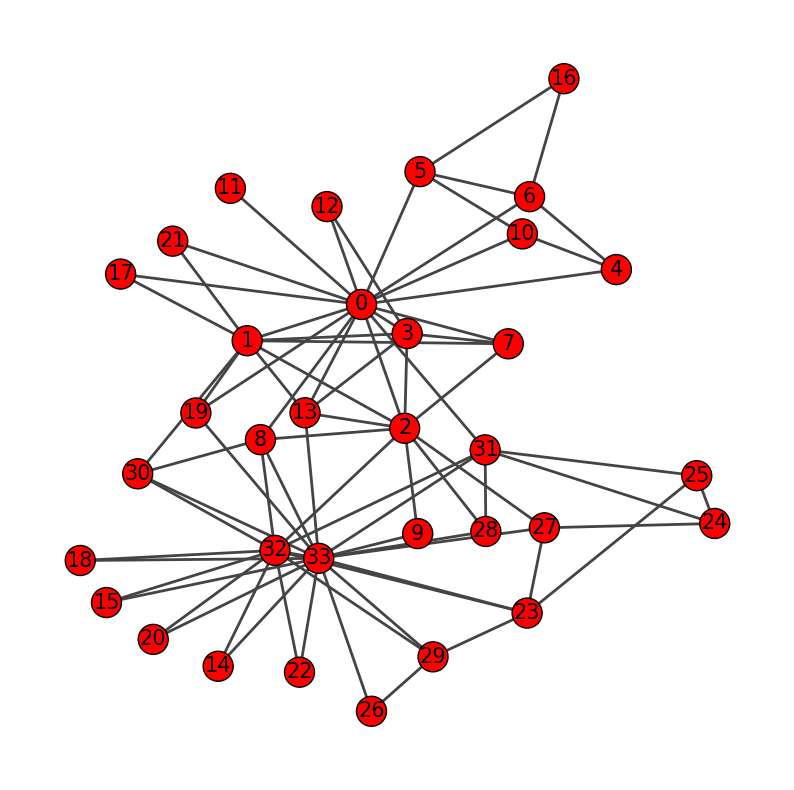

In [10]:
layout = g.layout("auto")
ig.plot(
    g,
    layout=layout,
    vertex_label=g.vs["member_id"],
    vertex_label_size=15
)

### Louvain implementation

In [11]:
# Extract adjacency matrix
adj_matrix = np.array(g.get_adjacency(attribute="weight").data)
print(adj_matrix)

[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [12]:
# Get node degrees
node_degrees = np.sum(adj_matrix, axis=1)
node_degrees

array([16,  9, 10,  6,  3,  4,  4,  4,  5,  2,  3,  1,  2,  5,  2,  2,  2,
        2,  2,  3,  2,  2,  2,  5,  3,  3,  2,  4,  3,  4,  4,  6, 12, 17])

In [13]:
node_degrees = np.expand_dims(node_degrees, axis=-1)
node_degrees.shape

(34, 1)

In [14]:
edge_sum = np.sum(node_degrees)/2

In [15]:
def calc_modularity(adj_matrix, node_degrees, cluster_ids, edge_sum, resolution=1):

    """
    Calculates resolution modified modularity.

    :param adj_matrix: Adjacency matrix,
    :param node_degrees: Array containing node degress.
    :param cluster_ids: Array containing cluster ids.
    :param edge_sum: Total edge sum.
    :param resolution: Resolution parameter, defaults to 1
    :return: Resolution modified modularity.
    """

    mod = 0
    # Find modularity for each cluster
    for cluster in np.unique(cluster_ids):
        # Select all nodes belonging to current cluster
        curr_clust_ids = np.where(cluster_ids==cluster)[0]
        curr_adj = adj_matrix[np.ix_(curr_clust_ids, curr_clust_ids)]
        curr_deg = node_degrees[curr_clust_ids, :]

        # original modularity formula
        mod+= (np.sum(curr_adj) - resolution*np.sum(curr_deg@curr_deg.T)/(edge_sum*2))/(edge_sum*2)

    return mod

In [ ]:
def modularity_change(curr_node, target_cluster, adj_matrix, cluster_ids, edge_sum, resolution=1):

    """
    Change in modularity when we assign standalone curr_node to the target_cluster.

    :param curr_node: Id of the node we consider moving to neighboring communities
    :param target_cluster: Cluster we are considering moving the node into
    :param adj_matrix: Adjacency matrix.
    :param cluster_ids: Array containing cluster if for each node.
    :param edge_sum: Total edge sum.
    :param resolution: Resolution, defaults to 1.
    :return: Change in modularity.
    """

    # Get target community nodes
    target_cluster_nodes = np.argwhere(
        cluster_ids==target_cluster
    ).flatten()

    # Weights of all edges connected to curr_node
    k_adj = adj_matrix[curr_node, : ]

    # Degree of curr node
    k_i = k_adj.sum()

    # Sigma_tot - weight of all edges that are connected
    # to the target cluster nodes
    k_i_in = k_adj[target_cluster_nodes].sum()*2
    sigma_tot = adj_matrix[target_cluster_nodes, :].sum()

    # change in modularity
    mod_change = k_i_in/(2*edge_sum) - resolution*sigma_tot*k_i/(2*edge_sum**2)

    return mod_change

In [ ]:
# Set parameters
RESOLUTION = 0.4
THRESHOLD = 1e-7

# Set initial cluster ids and adj matrix
cluster_ids = np.array(range(num_nodes))
adj_matrix = np.array(g.get_adjacency(attribute="weight").data)

# Prepare dataframe to store cluster ids
cluster_df = pd.DataFrame(index=range(adj_matrix.shape[0]))
cluster_df[0] = range(adj_matrix.shape[0])

col_counter = 1

# Louvain clustering iterations
while True:

    print('\n')
    print('New epoch starting')

    node_degrees = np.sum(adj_matrix, axis=1)
    node_degrees = np.expand_dims(node_degrees, axis=-1)
    edge_sum = np.sum(node_degrees)/2

    modularity = calc_modularity(
        adj_matrix=adj_matrix,
        node_degrees=node_degrees,
        cluster_ids=cluster_ids,
        edge_sum=edge_sum,
        resolution=RESOLUTION
    )

    start_cluster_ids = cluster_ids.copy()
    start_modularity = modularity.copy()

    # Modularity optimization
    while True:

        modularity_improved = False

        # Each iteration requires shuffled node list
        node_list = list(range(num_nodes))
        random.shuffle(node_list)

        print('Startin pass through the nodes.')
        # Iterate through all the nodes
        for node_i in node_list:

            # Get node neighbors, exclude the node itself
            node_neighbors = np.where(adj_matrix[node_i]>0)[0]
            node_neighbors = [neigh for neigh in node_neighbors if neigh != node_i]

            # Get neighboring communities
            neighbor_clusters = cluster_ids[node_neighbors]
            neighbor_clusters_unique = np.unique(neighbor_clusters)

            # Save node cluster identity
            node_cluster = cluster_ids[node_i]

            # Determine if node is a singleton node
            singleton_node = node_cluster not in neighbor_clusters

            # Make node identity "-1" - make it standalone node
            cluster_ids[node_i] = -1

            # Dict that stores modularity improvement when this
            # standalone node is assigned to neighboring communities
            modularity_improvements = {}

            # If node is already singleton, adding the node to its
            # own community brings no change in modularity
            if singleton_node:
                modularity_improvements[node_cluster] = 0

            # Iterate through neighboring communities
            for neighbor_cluster in neighbor_clusters_unique:

                mod_change = modularity_change(
                    curr_node=node_i,
                    target_cluster=neighbor_cluster,
                    adj_matrix=adj_matrix,
                    cluster_ids=cluster_ids,
                    edge_sum=edge_sum,
                    resolution=RESOLUTION
                )

                modularity_improvements[neighbor_cluster] = mod_change

            base_change = modularity_improvements.pop(node_cluster)

            # Detect community yielding highest modularity increase
            # Handle case when node is not connected to other communities
            if len(modularity_improvements) > 0:
                max_neigh, max_mod_chg = max(modularity_improvements.items(), key=lambda x: x[1])
            else:
                max_neigh, max_mod_chg = -1, -np.inf

            # Update node community, update modularity
            if max_mod_chg > base_change:

                cluster_ids[node_i] = max_neigh
                modularity += max_mod_chg - base_change
                modularity_improved = True

            else:

                cluster_ids[node_i] = node_cluster

        # If modularity was not improved during current pass,
        # end the modularity optimization step
        if not modularity_improved:
            break

    print('Starting resolution modified modularity is {}'.format(start_modularity))
    print('End resolution modified modularity is {}'.format(modularity))
    print('Num clusters is {}'.format(np.unique(cluster_ids).shape[0]))

    # If modularity was not improved enough during modularity
    # improvement step, stop the algorithm
    if start_modularity + THRESHOLD >= modularity:
        print('DONE !')
        break

    print('Merging communities')

    # Remap cluster ids to original node ids & perform aggregation

    # Get unique cluster ids, and give them new IDs 0:num_clust
    unique_clusters = np.unique(cluster_ids)
    cluster_map = {unique_clusters[i]: i for i in range(unique_clusters.shape[0])}
    cluster_ids = [cluster_map[clust_id] for clust_id in cluster_ids]

    # Assign new cluster id to each point
    multi_map_dict = {start_cluster_id: cluster_id for start_cluster_id, cluster_id in zip(start_cluster_ids, cluster_ids)}
    cluster_df[col_counter] = cluster_df[col_counter-1].map(multi_map_dict)
    col_counter += 1

    # Get new unique clusters in aggregated points
    unique_clusters = np.unique(cluster_ids)

    # Merge nodes
    new_adj_matrix = np.zeros([unique_clusters.shape[0], unique_clusters.shape[0]])

    # Populate the adjacency matrix
    for clust_i in range(unique_clusters.shape[0]):

        for clust_j in range(clust_i, unique_clusters.shape[0]):

            clust_i_ids = np.where(cluster_ids==unique_clusters[clust_i])[0]
            clust_j_ids = np.where(cluster_ids==unique_clusters[clust_j])[0]

            if clust_i == clust_j:
                new_adj_matrix[clust_i, clust_j] = np.sum(adj_matrix[np.ix_(clust_i_ids, clust_j_ids)])
            else:
                new_adj_matrix[clust_i, clust_j] = np.sum(adj_matrix[np.ix_(clust_i_ids, clust_j_ids)])
                new_adj_matrix[clust_j, clust_i] = new_adj_matrix[clust_i, clust_j]

    # Initialize new cluster ids
    adj_matrix = new_adj_matrix.copy()

    cluster_ids = np.arange(adj_matrix.shape[0])
    num_nodes = adj_matrix.shape[0]

In [ ]:
cluster_df

In [ ]:
layout = g.layout("auto")
ig.plot(
    g,
    layout=layout,
    vertex_label=cluster_df[2].values,
    vertex_size=0.3,
    vertex_label_size=15
)

In [ ]:
ig_clusters = g.community_multilevel(resolution=0.4)

In [ ]:
type(ig_clusters)

In [ ]:
type(g)

In [ ]:
ig_clusters.membership

In [ ]:
ig_clusters.modularity

In [ ]:
ig_clusters.graph == g

In [ ]:
ig.plot(ig_clusters)

In [ ]:
ig_cluster_ids = ig_clusters.membership

In [ ]:
layout = g.layout("auto")
ig.plot(g, layout=layout, vertex_label=ig_cluster_ids)